# DSCI 100 Group 29 Project: Classifying Dry Bean Type

**Group Members:** Janine Dang, Tarini Lavindran, Manuela Mezquita Garcia-Poggio, Saksham Saksham

## Introduction

Dry beans are a staple in kitchens around the world. In most developing countries, almost 50% legumes consumed are dry beans (Mamidi et al., 2011). Harvested beans are sorted by their physical characteristics, so it is crucial that producers develop an efficient system. With the help of new technology like computer vision systems (CVSs), classifying beans has become more efficient (Koklu & Ozkan, 2020). 

Project Question: Can we classify the type of dry bean based on its features, and if so, is it possible to create a classification with high accuracy based on a dataset of dry bean features? Which features will be best in determining bean type?

The dataset we are using is [the Dry Beans Dataset from UC Irvine](https://archive.ics.uci.edu/dataset/602/dry+bean+dataset), which was created in 2020 with the use of a high resolution camera and CVSs (Koklu & Ozkan, 2020). Researchers took images of 13,611 grains from the seven types of dry beans and applied segmentation and feature extraction processes to these images. The variables in this dataset are below.

|   **Variables**   | Description                              |
|:------------|:--------------------------------------------------------------------|
|  Area   |  The area of a bean in pixels.                                      |
|  Perimeter   |  The circumference of a bean in pixels.                        |
|  MajorAxisLength    |The longest line that can be drawn from a bean in pixels.|
|MinorAxisLength|The longest line that can be drawn from the bean perpendicular to the MajorAxisLength in pixels.|
|AspectRatio|The ratio of the bean’s MajorAxisLength and MinorAxisLength.|
|Eccentricity|The eccentricity of an ellipse with a value between 0 and 1, 0 being a perfect circle and 1 being a line segment.|
|ConvexArea|The number of pixels in the smallest convex polygon that can contain the area of a bean seed.|
|EquivDiameter|The diameter of a circle that has the same area as a bean seed area in pixels.|
|Extent|The ratio of the pixels outside the bean area to the pixels in the bean area.|
|Solidity|The convexity of a bean.|
|Roundness|$(4piArea)/(Perimeter^2)$|
|Compactness|Measures the roundness of a bean in pixels.|
|Shape Factor 1|$(MajorAxisLength / Area)$|
|Shape Factor 2|$(MinorAxisLength / Area)$|
|Shape Factor 3|$(Area / ((Shape Factor 1)^2 * pi))$|
|Shape Factor 4|$(Area / ((Shape Factor 1) * (Shape Factor 2) * pi))$|
|Class|The different types of beans: Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira.|

## Preliminary Exploratory Data Analysis

In [1]:
#load libraries

library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(dplyr)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

**Loading Our Data**

In [2]:
# URL of the dry bean dataset
dry_bean_url <- "https://raw.githubusercontent.com/janinedang/dsci-100-group_29/main/dry_bean_dataset.csv"

# Download the file from the URL onto our local computer
download.file(dry_bean_url, "dry_bean.csv")

# Read the csv file and rename the columns.
dry_bean <- read_csv("dry_bean.csv", col_names = FALSE, skip=1) |>
            rename("area" = X1,
                   "perimeter" = X2,
                   "major_axis_length" = X3,
                   "minor_axis_length" = X4,
                   "aspect_ratio" = X5,
                   "eccentricity" = X6,
                   "convex_area" = X7,
                   "equiv_diameter" = X8,
                   "extent" = X9,
                   "solidity" = X10,
                   "roundness" = X11,
                   "compactness" = X12,
                   "shape_factor_1" = X13,
                   "shape_factor_2" = X14,
                   "shape_factor_3" = X15,
                   "shape_factor_4" = X16,
                   "class" = X17) 

head(dry_bean)

Rows: 13611 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): X17
dbl (16): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


area,perimeter,major_axis_length,minor_axis_length,aspect_ratio,eccentricity,convex_area,equiv_diameter,extent,solidity,roundness,compactness,shape_factor_1,shape_factor_2,shape_factor_3,shape_factor_4,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
28395,610.291,208.1781,173.8887,1.197191,0.5498122,28715,190.1411,0.7639225,0.9888560,0.9580271,0.9133578,0.007331506,0.003147289,0.8342224,0.9987239,SEKER
28734,638.018,200.5248,182.7344,1.097356,0.4117853,29172,191.2728,0.7839681,0.9849856,0.8870336,0.9538608,0.006978659,0.003563624,0.9098505,0.9984303,SEKER
29380,624.110,212.8261,175.9311,1.209713,0.5627273,29690,193.4109,0.7781132,0.9895588,0.9478495,0.9087742,0.007243912,0.003047733,0.8258706,0.9990661,SEKER
30008,645.884,210.5580,182.5165,1.153638,0.4986160,30724,195.4671,0.7826813,0.9766957,0.9039364,0.9283288,0.007016729,0.003214562,0.8617944,0.9941988,SEKER
30140,620.134,201.8479,190.2793,1.060798,0.3336797,30417,195.8965,0.7730980,0.9908933,0.9848771,0.9705155,0.006697010,0.003664972,0.9419004,0.9991661,SEKER
30279,634.927,212.5606,181.5102,1.171067,0.5204007,30600,196.3477,0.7756885,0.9895098,0.9438518,0.9237260,0.007020065,0.003152779,0.8532696,0.9992358,SEKER


**1) Tidying and Wrangling the Data**

In [3]:
# Mutate the class vector to change the type of data from character <chr> to factor <fct>.
dry_bean_tidy <- dry_bean |>
                 mutate(class = as_factor(class))

head(dry_bean_tidy)

area,perimeter,major_axis_length,minor_axis_length,aspect_ratio,eccentricity,convex_area,equiv_diameter,extent,solidity,roundness,compactness,shape_factor_1,shape_factor_2,shape_factor_3,shape_factor_4,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28395,610.291,208.1781,173.8887,1.197191,0.5498122,28715,190.1411,0.7639225,0.9888560,0.9580271,0.9133578,0.007331506,0.003147289,0.8342224,0.9987239,SEKER
28734,638.018,200.5248,182.7344,1.097356,0.4117853,29172,191.2728,0.7839681,0.9849856,0.8870336,0.9538608,0.006978659,0.003563624,0.9098505,0.9984303,SEKER
29380,624.110,212.8261,175.9311,1.209713,0.5627273,29690,193.4109,0.7781132,0.9895588,0.9478495,0.9087742,0.007243912,0.003047733,0.8258706,0.9990661,SEKER
30008,645.884,210.5580,182.5165,1.153638,0.4986160,30724,195.4671,0.7826813,0.9766957,0.9039364,0.9283288,0.007016729,0.003214562,0.8617944,0.9941988,SEKER
30140,620.134,201.8479,190.2793,1.060798,0.3336797,30417,195.8965,0.7730980,0.9908933,0.9848771,0.9705155,0.006697010,0.003664972,0.9419004,0.9991661,SEKER
30279,634.927,212.5606,181.5102,1.171067,0.5204007,30600,196.3477,0.7756885,0.9895098,0.9438518,0.9237260,0.007020065,0.003152779,0.8532696,0.9992358,SEKER


**2)Seperating the data into training and testing sets**

In [4]:
set.seed(1234)
# Separate the dataset into training and testing sets. 
dry_bean_split <- initial_split(dry_bean_tidy, prop = 0.75, strata = class)

# Training set
dry_bean_train <- training(dry_bean_split)

# Testing set
dry_bean_test <- testing(dry_bean_split)


In [5]:
# Use glimpse to view the data with a large number of columns, where the columns go down the page,
# and on both training and testing sets to see if the initial data was split accordingly.

glimpse(dry_bean_train)
glimpse(dry_bean_test)

Rows: 10,207
Columns: 17
$ area              <dbl> 43145, 49317, 49777, 49975, 50166, 50683, 50798, 510…
$ perimeter         <dbl> 799.426, 886.931, 861.277, 873.529, 893.846, 905.491…
$ major_axis_length <dbl> 273.4029, 310.5631, 300.7570, 313.9997, 313.0216, 31…
$ minor_axis_length <dbl> 201.2669, 202.4589, 211.6169, 203.9383, 204.6558, 20…
$ aspect_ratio      <dbl> 1.358410, 1.533956, 1.421234, 1.539680, 1.529503, 1.…
$ eccentricity      <dbl> 0.6768132, 0.7582971, 0.7105824, 0.7603739, 0.756661…
$ convex_area       <dbl> 43812, 50400, 50590, 50699, 51209, 51613, 52164, 517…
$ equiv_diameter    <dbl> 234.3799, 250.5840, 251.7500, 252.2502, 252.7317, 25…
$ extent            <dbl> 0.7661233, 0.7130856, 0.8019107, 0.7147965, 0.762517…
$ solidity          <dbl> 0.9847759, 0.9785119, 0.9839296, 0.9857196, 0.979632…
$ roundness         <dbl> 0.8483671, 0.7878197, 0.8432433, 0.8230155, 0.789030…
$ compactness       <dbl> 0.8572690, 0.8068700, 0.8370543, 0.8033453, 0.807394…
$ shape_factor_

**Exploratory Data Analysis**

In [6]:
# Group and summarize to find how many beans exist in each class.
dry_bean_summarize <- dry_bean_train |>
                      group_by(class) |>
                      summarize(count = n()) |>
                      mutate(percent = 100 * count / nrow(dry_bean_train))

dry_bean_summarize

class,count,percent
<fct>,<int>,<dbl>
SEKER,1516,14.852552
BARBUNYA,976,9.562065
BOMBAY,423,4.144215
CALI,1226,12.011365
HOROZ,1437,14.078574
SIRA,1970,19.300480
DERMASON,2659,26.050749


**3)Selecting variables for prediction**

To find our predictors, we want to find trends between variables and the bean types. These trends typically occur when variables have strong relationships with each other. We will be using `cor()` and `ggpairs` to find these trends.

First, we will split our data into a smaller dataframe so that `ggpairs` can load the data points, then plot chunks of variables at a time as `ggpairs` runs slowly when plotting many variables for large amounts of data.

In [7]:
# Split training data into a smaller dataframe so that ggpairs can run it.
dry_bean_small <- initial_split(dry_bean_train, prop = 0.18, strata = class) |>
                  training()

Import library for `cor()` function

In [8]:
#install.packages("Hmisc")
library("Hmisc")


Attaching package: ‘Hmisc’


The following object is masked from ‘package:parsnip’:

    translate


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units




Now, we find the correlation between each predictor with one another to find the highest correlation between predictors.

In [9]:
dry_bean_correlation <- cor(select(dry_bean, -class))
dry_bean_correlation

,area,perimeter,major_axis_length,minor_axis_length,aspect_ratio,eccentricity,convex_area,equiv_diameter,extent,solidity,roundness,compactness,shape_factor_1,shape_factor_2,shape_factor_3,shape_factor_4
area,1.00000000,0.96672218,0.93183359,0.951601599,0.241734796,0.26748137,0.99993923,0.98496752,0.05434485,-0.1965845,-0.3575303,-0.268066825,-0.847958328,-0.6392907,-0.272144848,-0.3557214
perimeter,0.96672218,1.00000000,0.97733775,0.913178555,0.385275645,0.39106554,0.96768921,0.99138043,-0.02115958,-0.3039696,-0.5476467,-0.406856863,-0.864622945,-0.7675923,-0.408435296,-0.4293098
major_axis_length,0.93183359,0.97733775,1.00000000,0.826051550,0.550334771,0.54197162,0.93260701,0.96173336,-0.07806191,-0.2843023,-0.5963576,-0.568377073,-0.773608665,-0.8592376,-0.568184805,-0.4825272
minor_axis_length,0.95160160,0.91317856,0.82605155,1.000000000,-0.009161131,0.01957387,0.95133933,0.94853889,0.14595706,-0.1558308,-0.2103439,-0.015066473,-0.947204167,-0.4713470,-0.019326233,-0.2637490
aspect_ratio,0.24173480,0.38527565,0.55033477,-0.009161131,1.000000000,0.92429255,0.24330102,0.30364704,-0.37018356,-0.2677543,-0.7669793,-0.987687299,0.024592773,-0.8378412,-0.978592275,-0.4492641
eccentricity,0.26748137,0.39106554,0.54197162,0.019573875,0.924292554,1.00000000,0.26925479,0.31866708,-0.31936188,-0.2975923,-0.7222725,-0.970313022,0.019919682,-0.8601408,-0.981057697,-0.4493537
convex_area,0.99993923,0.96768921,0.93260701,0.951339329,0.243301025,0.26925479,1.00000000,0.98522625,0.05256368,-0.2061913,-0.3620826,-0.269922448,-0.847949735,-0.6408616,-0.274024160,-0.3620492
equiv_diameter,0.98496752,0.99138043,0.96173336,0.948538894,0.303647037,0.31866708,0.98522625,1.00000000,0.02838294,-0.2316477,-0.4359445,-0.327649979,-0.892740731,-0.7130686,-0.330389365,-0.3925118
extent,0.05434485,-0.02115958,-0.07806191,0.145957056,-0.370183561,-0.31936188,0.05256368,0.02838294,1.00000000,0.1913885,0.3444112,0.354211746,-0.141616424,0.2379557,0.347624414,0.1485024
solidity,-0.19658454,-0.30396957,-0.28430228,-0.155830824,-0.267754288,-0.29759231,-0.20619129,-0.23164769,0.19138854,1.0000000,0.6071500,0.303766114,0.153387620,0.3435593,0.307662465,0.7021629


Based on the correlation table above, we can see that the variables `area`, `perimeter`, `major_axis_length`, `minor_axis_length`, `convex_area`, `equiv_diameter`, `eccentricity`, `aspect_ratio`, `shape_factor_3`, and `compactness` all have correlation among each other that is greater than 0.9.
So, we can plot graphs using ggpairs to see their correlation between each other better.

Now, we will plot the variables `area`, `perimeter`, `major_axis_length`, `minor_axis_length`, and `aspect_ratio` against each other to visualize the correlation between these variables.

In [10]:
#options(repr.plot.height = 10, repr.plot.width = 12)
# See if the variables area, perimeter, major and minor axis lengths, and aspect ratio have any relationship with each other
#dry_bean_area_to_ar <- dry_bean_small |>
#                       select(area, perimeter, major_axis_length, minor_axis_length, aspect_ratio, class)

# Use ggpairs to see if the above mentioned variables have any correlation
#ggpairs(dry_bean_area_to_ar, columns = 1:5, aes(color = class, alpha = 0.5)) + 
#labs(tag = "Figure 1") +
#theme(axis.text.x = element_text(angle = 60, hjust = 1))

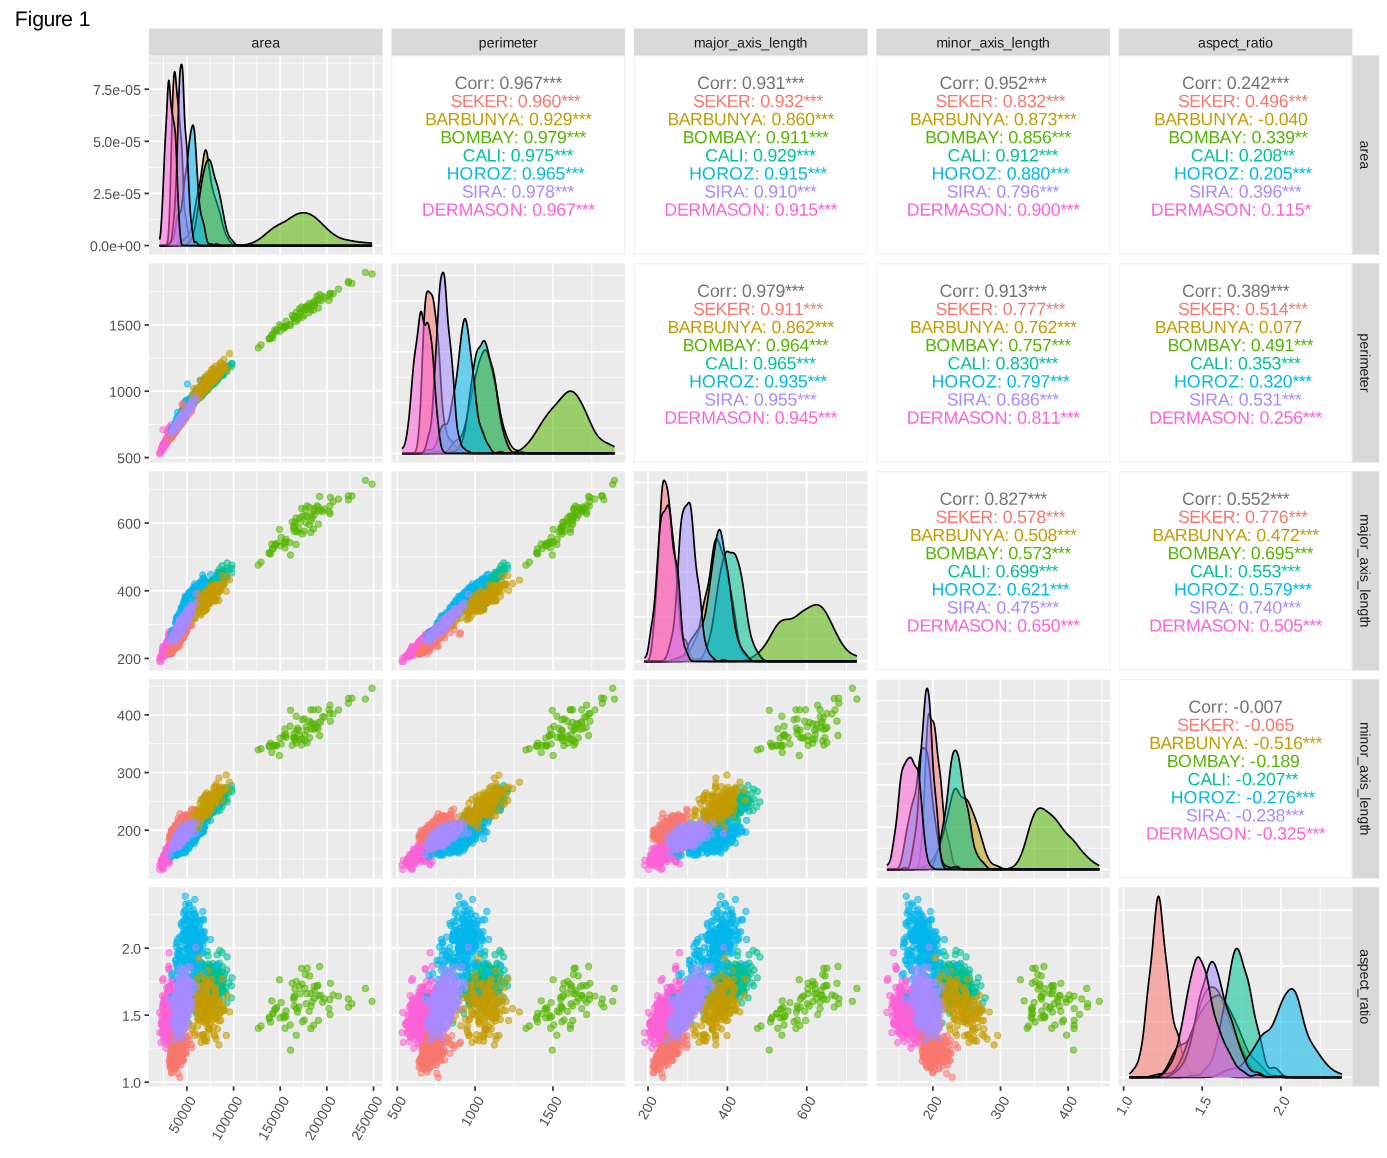

The variables `area`, `perimeter`, `major_axis_length`, and `minor_axis_length` have strong relationships, so these will be used as predictors.

Plot the variables `eccentricity`, `convex_area`, `equiv_diameter`, `convex_area`, `shape_factor_3` and `compactness` to find any correlations between these variables. 

In [11]:
#options(repr.plot.height = 10, repr.plot.width = 12)
# See if the variables eccentricity, convex area, equiv diameter, extent, and solidity have any relationship with each other
#dry_bean_ecc_to_sol <- dry_bean_small |>
#                       select(eccentricity, convex_area, equiv_diameter, convex_area, shape_factor_3, compactness , class)

# Use ggpairs to see if the above mentioned variables have any correlation
#ggpairs(dry_bean_ecc_to_sol, columns = 1:5, aes(color = class, alpha = 0.5)) +
#labs(tag = "Figure 2") +
#theme(axis.text.x = element_text(angle = 60, hjust = 1))

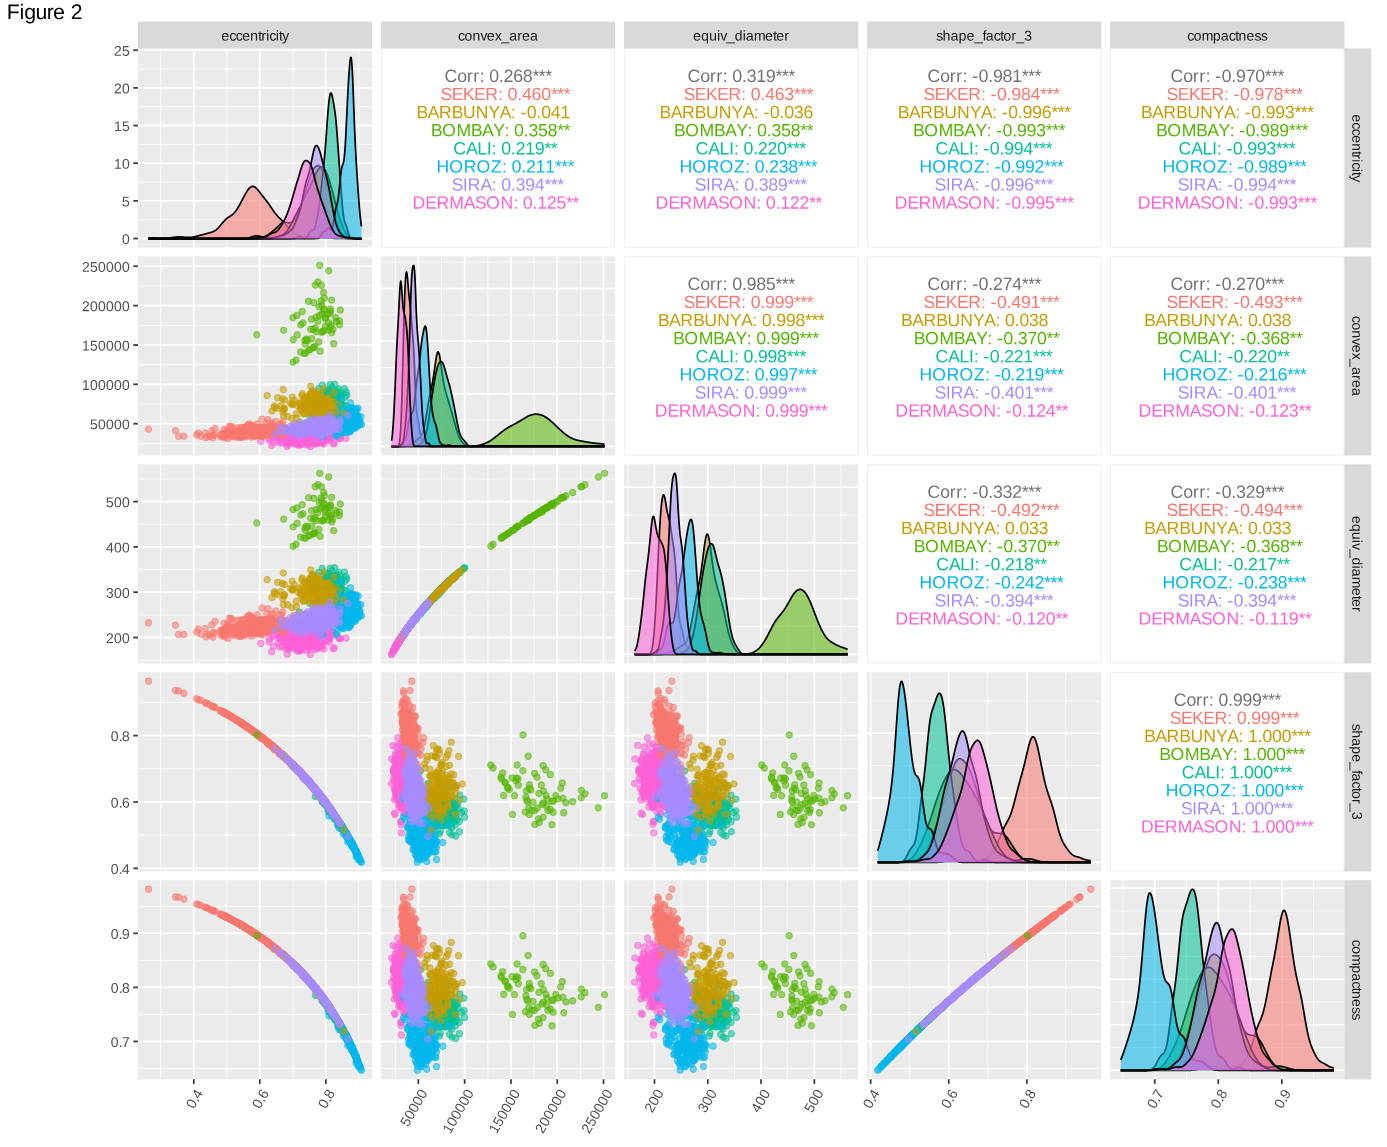

The variables `convex_area` and `equiv_diameter` have a strong relationship, and `shapefactor_3` and `compactness` also have a strong relationship so plot these against `area`, `perimeter`, `major_axis_length`, and `minor_axis_length` seperately as we cannot plot too many preditors at the same time due to our computation limitation, to find any correlations between these variables.
First we plot `convex_area`, `equiv_diameter`, `area`, `perimeter`, `major_axis_length`, and `minor_axis_length`

In [12]:
# options(repr.plot.height = 10, repr.plot.width = 12)
# See if the variables area, perimeter, major axis length, minor axis length, convex area, and equiv diameter have any correlation
# dry_bean_area_to_ed <- dry_bean_small |>
#                        select(area, perimeter, major_axis_length, minor_axis_length, convex_area, equiv_diameter, class)

# Use ggpairs to see if the above mentioned variables have any correlation
# ggpairs(dry_bean_area_to_ed, columns = 1:6, aes(color = class, alpha = 0.5)) +
# labs(tag = "Figure 3") +
# theme(axis.text.x = element_text(angle = 60, hjust = 1))

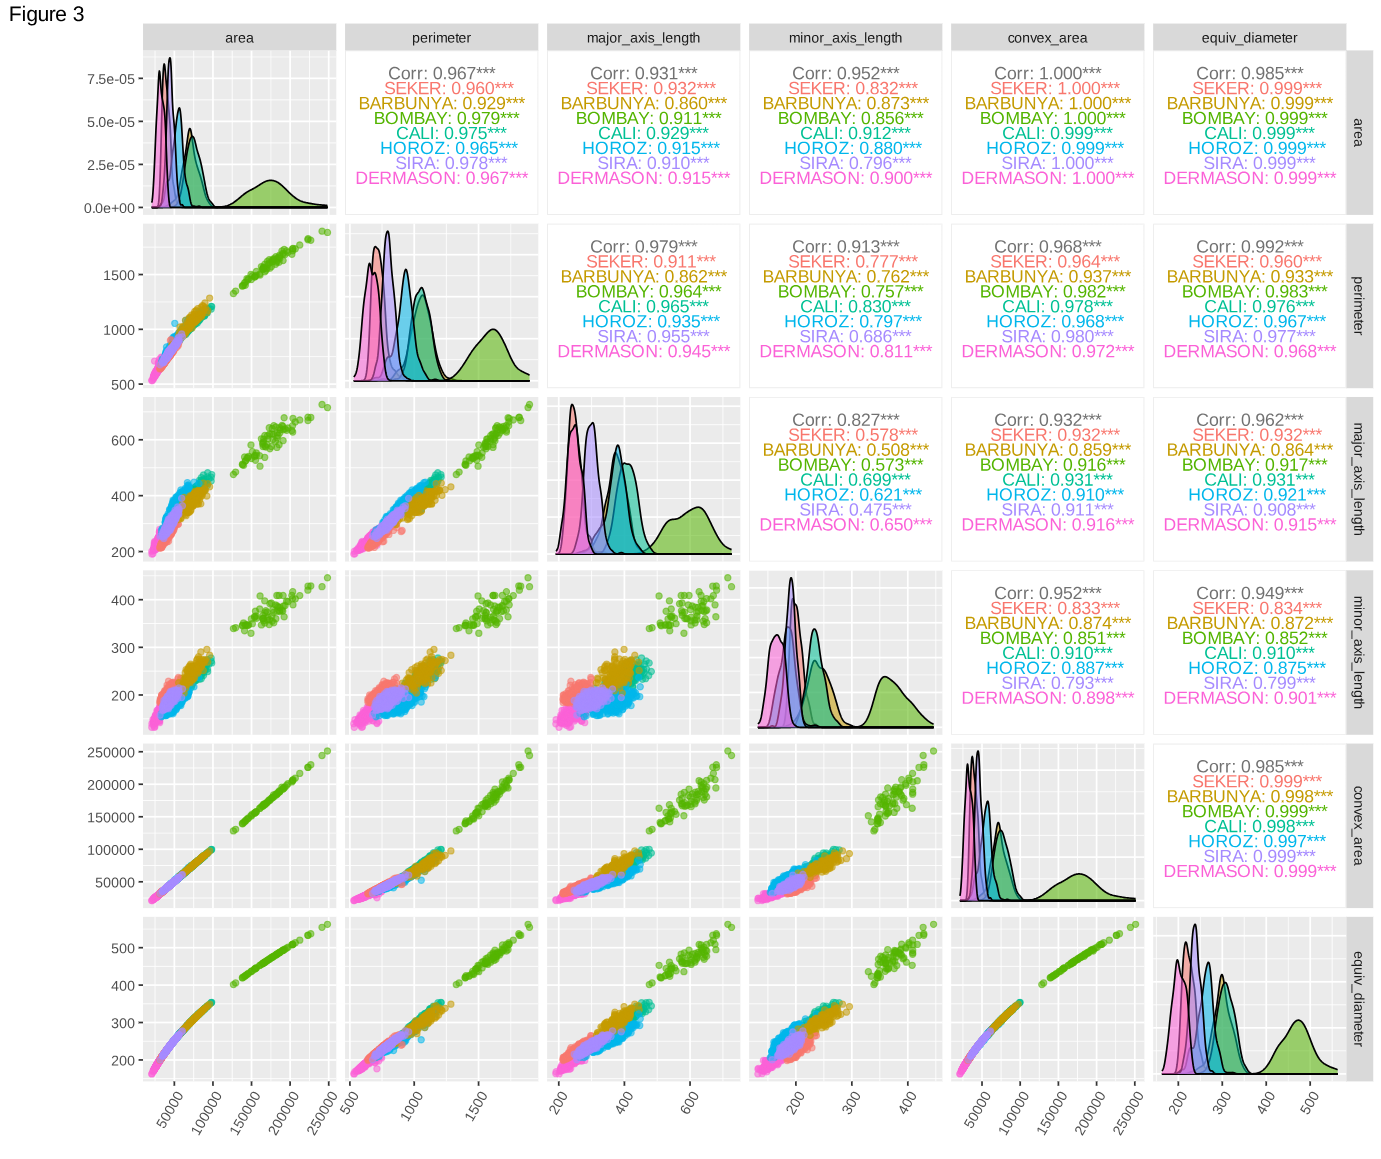

All of these variables have strong relationships, so we can use these variables as predictors.

Now, we plot `shapefactor_3`, `compactness`, `area`, `perimeter`, `major_axis_length`, and `minor_axis_length` to see thier correlation together.

In [13]:
# options(repr.plot.height = 10, repr.plot.width = 12)
# See if the variables roundness, compactness, shape factor 1, 2, 3, and 4 have any correlation
# dry_bean_roundness_to_sf4 <- dry_bean_small |>
#                             select(area, perimeter, major_axis_length, minor_axis_length, compactness, shape_factor_3, class)

# Use ggpairs to see if the above mentioned variables have any correlation
# ggpairs(dry_bean_roundness_to_sf4, columns = 1:6, aes(color = class, alpha = 0.5)) +
#  labs(tag = "Figure 4") +
# theme(axis.text.x = element_text(angle = 60, hjust = 1))

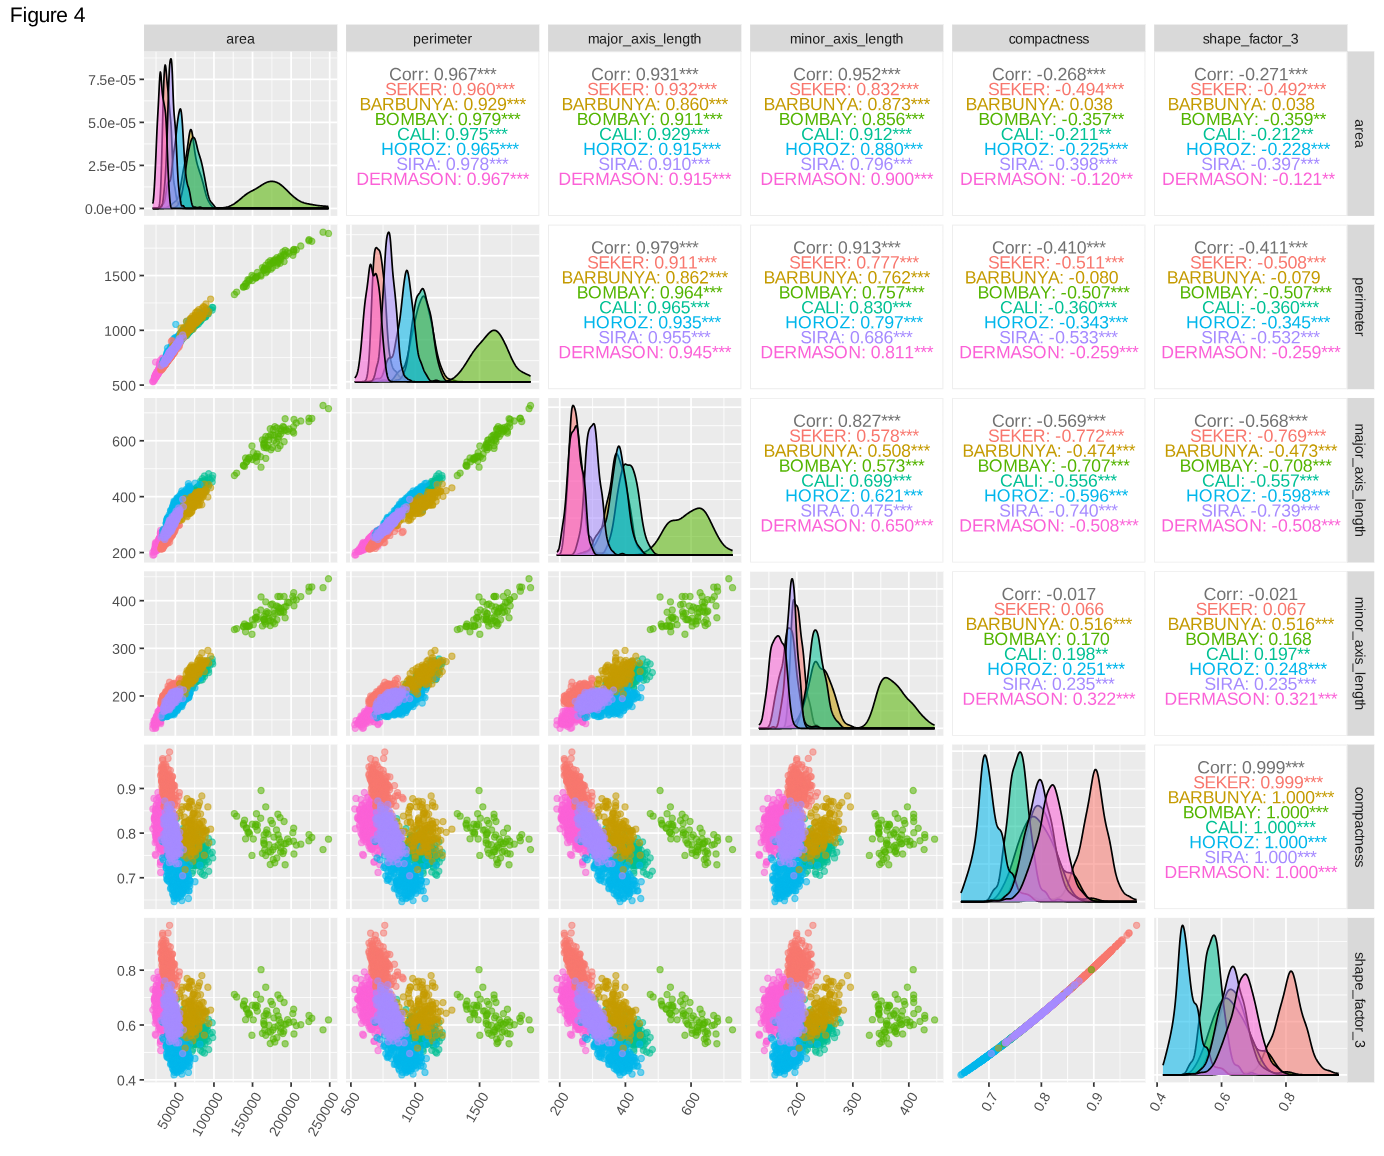

There is no relationship between our determined predictors and the new variables, so we will not use `compactness` and `shape_factor_3` as predictors.

Based on this, we can determine that our predictors will be `area`, `perimeter`, `major_axis_length`, `minor_axis_length`, `convex_area`, and `equiv_diameter`.

**4)Preprocessing the training data set**

Below, we split the training data further into a smaller proportion of 0.36 as the training data set is too large and the kernel keeps dying when the whole training data was used. This is a limitation to us due to our low computation power.

In [14]:
dry_bean_train_new <- initial_split(dry_bean_train, prop = 0.36, strata = class) |>
                      training()

set.seed(1234)

dry_bean_recipe <- recipe(class ~ area + perimeter + major_axis_length + minor_axis_length + convex_area + equiv_diameter, 
                          data = dry_bean_train_new) |>
                   step_scale(all_predictors()) |>
                   step_center(all_predictors())

dry_bean_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                 set_engine("kknn") |>
                 set_mode("classification")

dry_bean_fit <- workflow() |>
                add_recipe(dry_bean_recipe) |>
                add_model(dry_bean_spec) |>
                fit(data = dry_bean_train_new)

dry_bean_fit

Warning message:
“tune samples were requested but there were 3672 rows in the data. 3667 will be used.”


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(tune(),     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.7434641
Best kernel: rectangular
Best k: 3667

**5)Training the classifier**

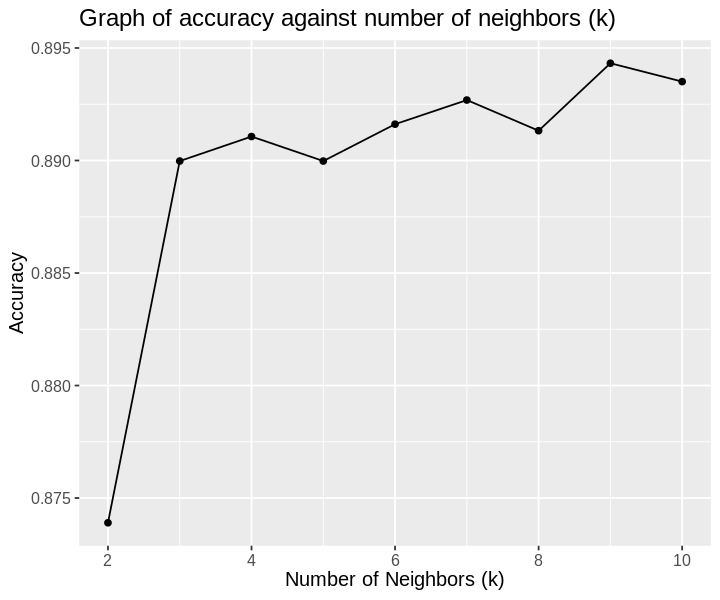

In [15]:
options(repr.plot.height = 5, repr.plot.width = 6)

dry_bean_vfold <- vfold_cv(dry_bean_train_new , v = 5, strata = class)

dry_bean_tibble <- tibble(neighbors = seq(from = 2, to = 10, by = 1))

vfold_metrics <- workflow() |>
                  add_recipe(dry_bean_recipe) |>
                  add_model(dry_bean_spec) |>
                  tune_grid(resamples = dry_bean_vfold, grid = dry_bean_tibble) |>
                  collect_metrics() |>
                  filter(.metric == "accuracy")

cross_val_plot <- ggplot(vfold_metrics, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Number of Neighbors (k)", y = "Accuracy") +
                  ggtitle("Graph of accuracy against number of neighbors (k)") +
                  theme(text = element_text(size = 12)) 

cross_val_plot

Based on the graph above, we can determine that the best K value for our data set is **K = 9**.

**Build our new model**

Now that we found the best K value, we can build our final classification model.

In [16]:
dry_bean_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
                       set_engine("kknn") |>
                       set_mode("classification")

dry_bean_final_fit <- workflow() |>
                      add_recipe(dry_bean_recipe) |>
                      add_model(dry_bean_final_spec) |>
                      fit(data = dry_bean_train_new)

We can use this new model on our training set and test its accuracy.

**6)Analysis and evaluation of our prediction**

In [17]:
dry_bean_predictions <- predict(dry_bean_final_fit, dry_bean_test) |>
                        bind_cols(dry_bean_test)

dry_bean_metrics <- dry_bean_predictions |> 
                    metrics(truth = class, estimate = .pred_class) |>
                    filter(.metric == "accuracy")

dry_bean_conf_mat <- dry_bean_predictions |>
                     conf_mat(truth = class, estimate = .pred_class) 

dry_bean_metrics
dry_bean_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9007051


          Truth
Prediction SEKER BARBUNYA BOMBAY CALI HOROZ SIRA DERMASON
  SEKER      475        2      0    0     0    6       15
  BARBUNYA     2      283      0   13     3    0        0
  BOMBAY       0        1     99    0     0    0        0
  CALI         0       45      0  380    14    2        0
  HOROZ        0        5      0    7   450   12        1
  SIRA        22       10      0    4    19  563       55
  DERMASON    12        0      0    0     5   83      816

## 

## Methods

**1. Cleaning up the data**

* Translate all non-English values that are not numerical in the raw data set into English and change the type of `class` from character to factor.

**2. Separate the dataset into training and testing sets**

* ⁠Set a specific seed using `set.seed` for the random split of our dataset into the training and testing sets so that the data analysis process can be reproduced.
* ⁠Using `initial_split`, randomly divide 75% of the data into a training set and 25% into a testing set.

**3. Selecting the variables for prediction**

* From using `ggpairs` in our preliminary data analysis, the variables we will use as predictors are `area`, `perimeter`, `major_axis_length`, `minor_axis_length`, `convex_area`, and `equiv_diameter`.

**4. Preprocessing the training data set**

* ⁠Create a recipe for the classification model using our predictors, then scale and center the values in the training data set using `recipe`, `step_scale`, and `step_center`.

**5. Training the classifier**

* Determine the best K value for the nearest neighbor algorithm for this data set using cross validation and `vfold_cv`.
* ⁠After determining the K value, create a specification for the classification algorithm using our K value.
* Create a workflow for fitting by adding the recipe and the model using `workflow`.

**6. Presenting the data**

* ⁠We can plot the accuracy estimate against the number of neighbors to show which K value to choose using `geom_point` and `geom_line`.
* We can also plot graphs of different K values to check for overplotting and underplotting.

**7. Analysis and evaluation of our prediction**

* ⁠Reflect on the overall accuracy of our classification model.
* ⁠Think about real-life implications of the data and the conclusion that can be drawn from its analysis, then reflect on whether our classification model can benefit the process of crop production.


## Expected Outcomes and Significance

We expect that using the variables `area`, `perimeter`, `major_axis_length`, `minor_axis_length`, `convex_area`, and `equiv_diameter` as predictors in a classification model will accurately determine bean type. 

The significance of being able to accurately classify the type of dry beans is much greater than one may think. Being able to create technology that precisely identifies types of beans means that this technology could be used on a larger scale in the agriculture industry. Our dry bean type classifier has big implications, not just for the dry bean industry, but also for the agriculture sector and society as a whole, as “the accurate identification of crop type is essential for the management of land, food security, and further policy planning” (Kumar et al., 2022).

Our project could lead to broader use of classification models in the agriculture industry, such as being used to streamline or automate processes and increase efficiency, and more research being done into how CVSs can be used in agriculture.

---
## Citations

Koklu, M., & Ozkan, I. A. (2020). Multiclass classification of dry beans using computer vision and Machine Learning Techniques. Computers and Electronics in Agriculture, 174, 105507. https://doi.org/10.1016/j.compag.2020.105507 

Kumar, S., Meena, R. S., Sheoran, S., Jangir, C. K., Jhariya, M. K., Banerjee, A., & Raj, A. (2022). Remote Sensing for agriculture and Resource Management. Natural Resources Conservation and Advances for Sustainability, 91–135. https://doi.org/10.1016/b978-0-12-822976-7.00012-0 

Mamidi, S., Rossi, M., Annam, D., Moghaddam, S., Lee, R., Papa, R., & McClean, P. (2011). Investigation of the domestication of common bean (phaseolus vulgaris) using multilocus sequence data. Functional Plant Biology, 38(12), 953. https://doi.org/10.1071/fp11124  